# 5. Supervised Learning - Fine-tuning BERT model using ChatGPT GPT-4 Labels

### Name: Bingfeng Hu
### CID: 01137798

I declare that the below is of my own work, and I have worked on this assignment independently. Please see the cell below for package dependencies, uncomment to install the package dependencies.


Please note that I am running the notebook on [Google Collab](https://colab.research.google.com/) to be able to train deep models on GPU (to fine tune the pretrained base BERT model).

For Collab - upload the contents of the `combined_data_output` folder on Google drive and run the Google Colab commands below to save the files in your Google Colab environment

Here in particular we will take the training, validation and test sets which we've created from notebook 4 saved in the `combined_data_output` folder and use it to fine-tune a base BERT model using the Logistic Regression Model as a benchmark.

In [1]:
# # Run following cell for package dependencies
# !pip install jupyter pandas==2.1.1 seaborn==0.13.0
# !pip install scikit-learn==1.3.2 nltk==3.8.1
# !pip install torch torchvision transformers==4.35.2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!mkdir combined_data_output
!cp gdrive/MyDrive/combined_data_output/news_analysis_train_set.json combined_data_output/ # copy all the files over to the data folder from the question
!cp gdrive/MyDrive/combined_data_output/news_analysis_validation_set.json combined_data_output/
!cp gdrive/MyDrive/combined_data_output/news_analysis_test_set.json combined_data_output/

In [4]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

# basic sklearn preprocessing dependencies
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import re
import nltk


# SET THE SEED for replication.
SEED = 30224
np.random.seed(SEED)

In [5]:
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from nltk.tokenize import sent_tokenize, word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# setup additional dependencies for model training
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## 1. Load in the data - Training and Validation

Take the training and test sets, and combine them together.

In [6]:
# set up the same data cleaner for sentiment analysis used for logistic regression
news_train_df = pd.read_json("combined_data_output/news_analysis_train_set.json")
news_train_df.shape

(2612, 47)

In [7]:
news_validation_df = pd.read_json("combined_data_output/news_analysis_validation_set.json")
news_validation_df.shape

(653, 47)

In [8]:
# training set max row
train_max_row = news_train_df.shape[0]
train_max_row

2612

In [9]:
news_df = pd.concat([news_train_df, news_validation_df], axis = 0)

news_df.shape

# use this for the relevant texts for news workflow

(3265, 47)

In [10]:
# nltk.download('wordnet')

In [11]:
own_stopword = {'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because',
            'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'd', 'did', 'do', 'does', 'doing', 'down', 'during',
            'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself',
            'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'more', 'most', 'my', 'myself',
            'no', 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same',
            'she', "she's", 'should', "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves',
            'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'we', 'were', 'what',
            'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', 'y', 'you', "you'd", "you'll", "you're", "you've", 'your',
            'yours', 'yourself', 'yourselves'}

In [12]:
def data_cleaner_sa(text, return_tokens = False):
    '''
    Cleans the data from special characters, urls, punctuation marks, extra spaces.
    Removes stopwords (Like if, it, the etc) and transforms the word in its native
    form using Porter Stemmer.
    '''
    text = str(text).lower() # lowercase the string
    text = re.sub('\[.*?\]', ' ', text) # replace punctuation with whitespaces.
    text = re.sub('https?://\S+|www\.\S+', ' ', text) # replacing urls with whitespaces.
    text = re.sub('<.*?>+', ' ', text) # removes special characters
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # removes punctuation
    text = re.sub('\r', ' ', text) # removes new line characters
    text = re.sub('\n', ' ', text) # removes new line characters
    text = re.sub('\w*\d\w*', ' ', text)
    #text = re.sub('–', ' ', text) # remove any additional characters we cannot remove
    text = re.sub('[–£…»]', ' ', text) # remove any additional characters we cannot remove
    text = text.split()

    # removing stopwords.
    text = [word for word in text if not word in own_stopword]

    # stemming.
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text]

    if return_tokens:

        # return relevant tokens here where needed
        return text

    #List to string.
    text = ' '.join(text)

    return text

In [13]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3265 entries, 0 to 652
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   organizations                      3265 non-null   object
 1   uuid                               3265 non-null   object
 2   author                             3265 non-null   object
 3   url                                3265 non-null   object
 4   ord_in_thread                      3265 non-null   int64 
 5   title                              3265 non-null   object
 6   locations                          3265 non-null   object
 7   highlightText                      3265 non-null   object
 8   language                           3265 non-null   object
 9   persons                            3265 non-null   object
 10  text                               3265 non-null   object
 11  external_links                     3265 non-null   object
 12  publish

In [14]:
train_max_row

2612

## 2. Training Logistic Regression Model

In [15]:
# get the texts for logistic regression with this workflow
texts = news_df["text_full_raw_preprocessed"].to_list()
labels = news_df["prediction"].astype(int).to_list()
# convert labels to 0 and 1 rather than 1 and -1
labels = [1 if x == 1 else 0 for x in labels]

In [16]:
labels[:10]

[1, 1, 1, 0, 0, 0, 0, 0, 1, 1]

In [17]:
news_df["prediction"].astype(int).to_list()[:10] # correct so can run the rest of the code here

[1, 1, 1, -1, -1, -1, -1, -1, 1, 1]

In [18]:
lgr_preprocessed_text = [data_cleaner_sa(text) for text in texts]
lgr_preprocessed_text[:5] # preprocessing seems good enough so we can pass in the values directly.

['aldermor profit doubl float thu aug bst uk market close aldermor profit doubl float tim wallac telegraph hour ago challeng bank increas mortgag sme lend keep cost challeng hamburg hm news bank aldermor doubl profit first half year attract mortgag small busi custom door first set interim financi result sinc float stock market march bank report underli pre tax profit doubl net interest incom shot new loan level increas period lend small busi climb residenti mortgag lend increas six month june time margin improv aldermor kept cost net interest margin expand “we’v abl hold margin we’v abl drive cost fund ” said chief execut phillip monk ad aldermor challeng big bank deposit well lend “we’v focus deposit sme badli serv liabil side asset side balanc sheet they’v come us partli innov allow open fund account within minut ” bank’ oper incom grew cost rose push cost incom ratio mr monk said bank target ratio less end would make far effici biggest bank sector aldermore’ stock market flotat init

In [19]:
lgr_vectoriser = TfidfVectorizer(max_features=1000) #' get the top 1000 words'
X_lgr = lgr_vectoriser.fit_transform(lgr_preprocessed_text)

In [20]:
X_lgr.shape

(3265, 1000)

In [21]:
X_lgr[:train_max_row,:].shape,X_lgr[train_max_row:,:].shape

((2612, 1000), (653, 1000))

In [22]:
len(labels[:train_max_row]), len(labels[train_max_row:])

(2612, 653)

In [23]:
# split the data into the train validation splits

X_lgr_train, X_lgr_test, y_lgr_train, y_lgr_val = X_lgr[:train_max_row,:], X_lgr[train_max_row:,:], labels[:train_max_row], labels[train_max_row:]

In [24]:
# train the logistic regression model.
lgr_model = LogisticRegression()
lgr_model.fit(X_lgr_train, y_lgr_train)

LogisticRegression()

In [25]:
lgr_probabilities = lgr_model.predict_proba(X_lgr_test)

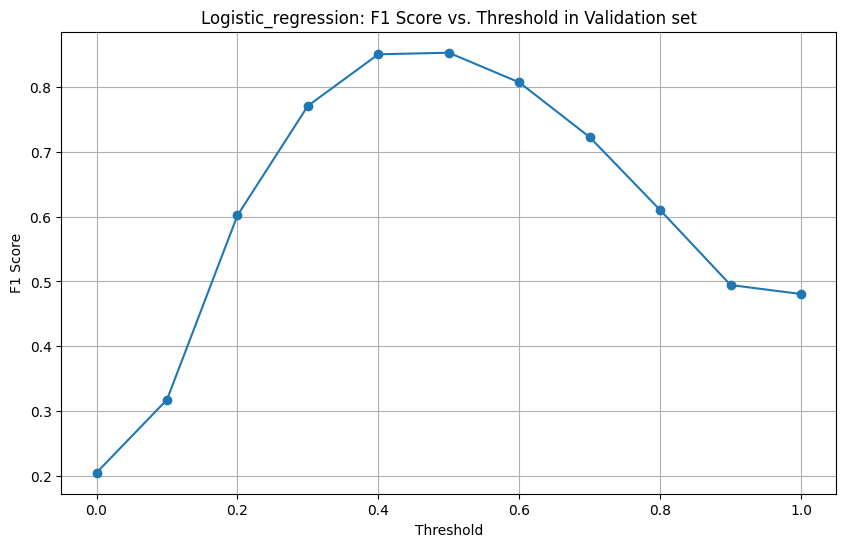

In [26]:
# graph threshold for all data points
lgr_thresholds = np.arange(0, 1.1, 0.1)
f1_scores = []

for threshold in lgr_thresholds:
    y_pred_threshold = np.where(lgr_probabilities[:, 1] >= threshold, 1, 0)
    score = f1_score(y_lgr_val, y_pred_threshold, average='weighted')
    f1_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(lgr_thresholds, f1_scores, marker='o')
plt.title('Logistic_regression: F1 Score vs. Threshold in Validation set')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)

In [27]:
np.argmax(f1_scores)

5

In [28]:
f1_scores[:6]

[0.20472583280183632,
 0.31742432667715015,
 0.6017302644720197,
 0.7709279138556038,
 0.8505254068364694,
 0.8529291653643774]

In [29]:
# put the labels as 1 or -1 since that is the labels we've given our models

In [30]:
# given the above we choose 0.5

# apply a threshold and get model predictions, like nlp lab video
lgr_threshold = 0.5
y_pred_threshold = np.where(lgr_probabilities[:, 1] >= lgr_threshold, 1, 0)

# Get the model performance on the
# use similar methods for pretrained bert model to compare.
print("Accuracy with threshold:", accuracy_score(y_lgr_val, y_pred_threshold))
print("Precision with threshold:", precision_score(y_lgr_val, y_pred_threshold, average='weighted'))
print("Recall with threshold:", recall_score(y_lgr_val, y_pred_threshold, average='weighted'))
print("F1 Score with threshold:", f1_score(y_lgr_val, y_pred_threshold, average='weighted'))

Accuracy with threshold: 0.8545176110260337
Precision with threshold: 0.853627507120399
Recall with threshold: 0.8545176110260337
F1 Score with threshold: 0.8529291653643774


## 3. Fine-tuning the pretrained BERT model


Here, instead of using hand engineered features, here we will use the ones which are generated from a pre-trained Bert model. In particular, we will use the `bert-base-uncased`, from [Huggingface]()

Here we will not use any preprocessing and tokenising tools we've previously built, but instead use the Tokenisers which are specific to this particular BERT model.

In [31]:
import torch
from torch import nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset

In [32]:
# review of the original texts and labels

texts = news_df["text_full_raw_preprocessed"].to_list()
labels = news_df["prediction"].astype(int).to_list()
# convert labels to 0 and 1 rather than 1 and -1
labels = [1 if x == 1 else 0 for x in labels]

texts[:4], labels[:4]

(['Aldermore profits double after float\n \nThu, Aug 27, 2015, 18:18 BST - UK Markets closed Aldermore profits double after float By Tim Wallace | Telegraph – 3 hours ago 0.000 \nThe challenger bank increased mortgage and SME lending, while keeping costs down \nChallenger (Hamburg: 4SE.HM - news ) bank Aldermore more than doubled its profits in the first half of the year as it attracted more mortgage and small business customers through its doors. \nIn its first set of interim financial results since floating on the stock market in March, the bank reported that underlying pre-tax profits more than doubled to £44m. \nNet interest income shot up 50pc, as new loan levels increased 14pc to £1.2bn over the period. \nLending to small businesses climbed by 12pc to £2.5bn while residential mortgage lending increased by 14pc to £2.9bn in the six months to June 30. \nAt the same time margins improved as Aldermore kept its own costs down its net interest margin expanded to 3.6pc. \n“We’ve been ab

In [33]:
# SET A MANUAL SEED FOR MODEL CONSISTENCY

generator = torch.Generator()
generator.manual_seed(SEED)

In [34]:
news_df.head()

,organizations,uuid,author,url,ord_in_thread,title,locations,highlightText,language,persons,...,thread_replies_count,thread_uuid,entities_persons,entities_locations,entities_organizations,word_count,text_full,token_count,prediction,text_full_raw_preprocessed
0,[],e54ffc6bbb4a7bdaead44e38b79f1875e20e98d1,,https://uk.finance.yahoo.com/news/aldermore-pr...,0,Aldermore profits double after float,[],,english,[],...,0,e54ffc6bbb4a7bdaead44e38b79f1875e20e98d1,[],[],[],383,Aldermore profits double after float\nTip : Us...,502,1,"Aldermore profits double after float\n \nThu, ..."
1,[],8706bea91c444eea3a79081513e9176c356bf09f,,https://uk.finance.yahoo.com/news/indias-centr...,0,India's central bank cuts key interest rate to...,[India],,english,[],...,0,8706bea91c444eea3a79081513e9176c356bf09f,[],[],[],298,India's central bank cuts key interest rate to...,398,1,India's central bank cuts key interest rate to...
2,[],c965dfbecdd6be07d6c425b8605803fb6ad23dda,Reuters,http://www.reuters.com/article/2015/10/23/mexi...,0,UPDATE 1-Mexican jobless rate falls to 4.2 per...,[],,english,[],...,0,c965dfbecdd6be07d6c425b8605803fb6ad23dda,[],[],[],126,UPDATE 1-Mexican jobless rate falls to 4.2 per...,190,1,UPDATE 1-Mexican jobless rate falls to 4.2 per...
3,[],34615e6ec43c970d7b51e1052f97fd900495e889,Reuters,http://www.reuters.com/article/2015/08/20/turk...,0,Turkey's banks need to prepare for slower lend...,[],,english,[],...,0,34615e6ec43c970d7b51e1052f97fd900495e889,[],[],[],292,Turkey's banks need to prepare for slower lend...,358,-1,Turkey's banks need to prepare for slower lend...
4,[],65b27f91af7260ed964902cd96fbba9b4023d305,,https://uk.finance.yahoo.com/news/brazil-keep-...,0,Brazil to keep key interest rate at 14.25%,[Brazil],,english,[],...,0,65b27f91af7260ed964902cd96fbba9b4023d305,[],[],[],235,Brazil to keep key interest rate at 14.25%\nTi...,318,-1,Brazil to keep key interest rate at 14.25%\n \...


In [35]:
train_max_row

2612

In [36]:
# separate the pretrained data into training and validation sets, set the seed consistently, to replicate the approach as before.

train_texts, val_texts, train_labels, val_labels = texts[:train_max_row], texts[train_max_row:], labels[:train_max_row], labels[train_max_row:]

In [37]:
len(train_texts), len(val_texts), len(train_labels), len(val_labels)

(2612, 653, 2612, 653)

In [38]:
# check if we're training on cpu or gpu
# and ensure that the data from the network is moved to the appropriate device for training and evaluation.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [39]:
# use hugging face transformer model
tokeniser = BertTokenizer.from_pretrained('bert-base-uncased')
pretrained_bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [40]:
# freeze all layers in bert so that we only do fine tuning

for param in pretrained_bert_model.parameters():
    param.requires_grad = False

In [41]:
# create a custom dataset class for text classification based around our data.
# overload dunder methods to create a key, vector encoding, and label for each data label item

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokeniser):
        # get the labels and vectorised tokens, and corresponding labels
        self.encodings = tokeniser(texts, max_length=512, padding=True, truncation=True, return_tensors='pt') # specify max length to be 512, although this is the case set by default
        self.labels = labels

    def __getitem__(self, idx):
        # return each data item
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [42]:
# define a bert classifier using a similar approach as in Assignment 1
# but the class now allows us to instantiate a moodel by passing a pretrained Bart model
# and use it as part of the network.

class BertTextClassifier(nn.Module):
    def __init__(self, pretrained_bert_model):
        super(BertTextClassifier, self).__init__()
        self.bert = pretrained_bert_model
        self.classifier = nn.Linear(pretrained_bert_model.config.hidden_size, 1)

        # outputs raw logit values
        # we will fine-tune this layer as all bert model parameters/weights are frozen
        self.classifier_raw_logit = nn.Linear(pretrained_bert_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # use the pooled output from huggingface bert as the embedding of our input sequence text.
        # which is returned from the pretrained huggingface huggingface model we've attached.
        # https://stackoverflow.com/questions/60243099/what-is-the-meaning-of-the-second-output-of-huggingfaces-bert
        # https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel

        pooled_output = outputs.pooler_output

        # outputs raw logit values as part of the model output
        return self.classifier_raw_logit(pooled_output)

Create the model and data objects for the model training pipeline

In [43]:
# create the datasets and data loaders
train_dataset = TextDataset(train_texts, train_labels, tokeniser)
val_dataset = TextDataset(val_texts, val_labels, tokeniser)

# data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, generator = generator) # use predefined generator to get the relevant seed.
val_loader = DataLoader(val_dataset, batch_size=16)

In [44]:
# instantiate the model and optimisers and loss function

# create a new model from a pretrained model - standard transfer learning workflow
bert_lgr_classifier = BertTextClassifier(pretrained_bert_model).to(device)
optimizer = torch.optim.Adam(bert_lgr_classifier.parameters(), lr=1e-3)

# use Logit loss since we use a raw model and we're doing binary classification
# therefore we take the binary classification loss function, based on raw logic values
binary_logit_loss = nn.BCEWithLogitsLoss()

In [45]:
# SET THE NUMBER OF EPOCHS

EPOCHS = 30

In [47]:
#15 minutes to evaluate this - try other approach - to save time later

# store losses
train_losses = []
val_losses = []

# training loop
bert_lgr_classifier.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = bert_lgr_classifier(input_ids, attention_mask)
        loss = binary_logit_loss(outputs.squeeze(), labels.float())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # validation loop - get average loss in loop to review the performance
    bert_lgr_classifier.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = bert_lgr_classifier(input_ids, attention_mask)
            val_loss = binary_logit_loss(outputs.squeeze(), labels.float())
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

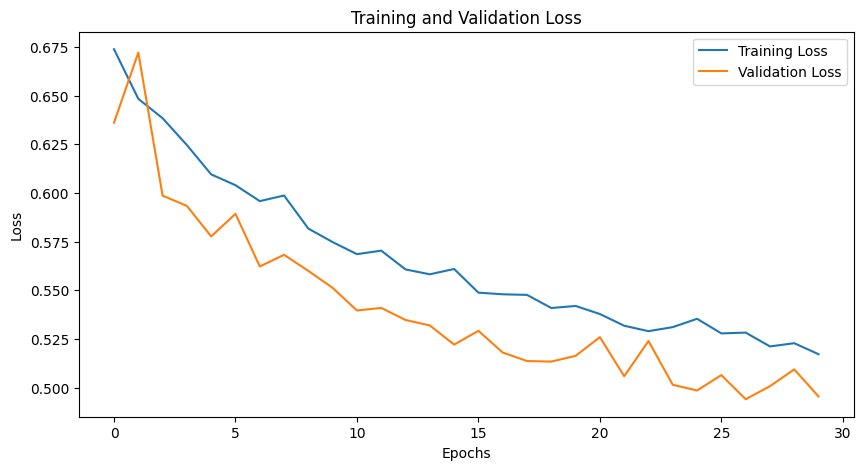

In [48]:
# visualise train validation loss

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [50]:
# run the code below to find the optimal threshold

In [51]:
# evaluation workflow
bert_lgr_classifier.eval()
predictions = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        logits = bert_lgr_classifier(input_ids, attention_mask) # model computes the raw logits here
        predictions += torch.sigmoid(logits).squeeze().tolist()



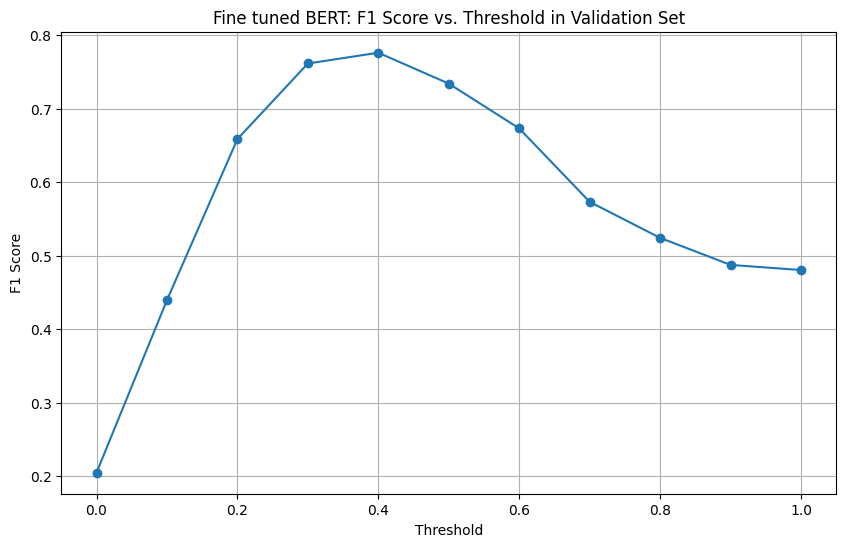

In [52]:
# define thresholds
thresholds = np.arange(0, 1.1, 0.1)
f1_scores = []

# Calculate F1 score for each threshold
for threshold in thresholds:
    predictions_arr = [1 if p > threshold else 0 for p in predictions]
    score = f1_score(val_labels, predictions_arr, average='weighted')
    f1_scores.append(score)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.title('Fine tuned BERT: F1 Score vs. Threshold in Validation Set')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [53]:
# RESET THRESHOLD FOR PRECISION

bert_threshold = 0.4 

In [54]:
# get binary prediction from probabilities

# get the negative class as -1 prediction based on the unique labelling of the code
predictions_arr = [1 if p > bert_threshold else 0 for p in predictions]

# Calculate accuracy
score = f1_score(val_labels, predictions_arr, average='weighted')
print("Accuracy with threshold:", accuracy_score(val_labels, predictions_arr))
print("Precision with threshold:", precision_score(val_labels, predictions_arr, average='weighted'))
print("Recall with threshold:", recall_score(val_labels, predictions_arr, average='weighted'))
print("F1 Score with threshold:", f1_score(val_labels, predictions_arr, average='weighted'))

Accuracy with threshold: 0.781010719754977
Precision with threshold: 0.7781790059243444
Recall with threshold: 0.781010719754977
F1 Score with threshold: 0.77625068945305


In [55]:
# save scores as variables

# logistic regression scores
accuracy_lgr = accuracy_score(y_lgr_val, y_pred_threshold)
precision_lgr = precision_score(y_lgr_val, y_pred_threshold, average='weighted')
recall_lgr = recall_score(y_lgr_val, y_pred_threshold, average='weighted')
f1_lgr = f1_score(y_lgr_val, y_pred_threshold, average='weighted')

# bert model scores
accuracy_model2 = accuracy_score(val_labels, predictions_arr)
precision_model2 = precision_score(val_labels, predictions_arr, average='weighted')
recall_model2 = recall_score(val_labels, predictions_arr, average='weighted')
f1_model2 = f1_score(val_labels, predictions_arr, average='weighted')


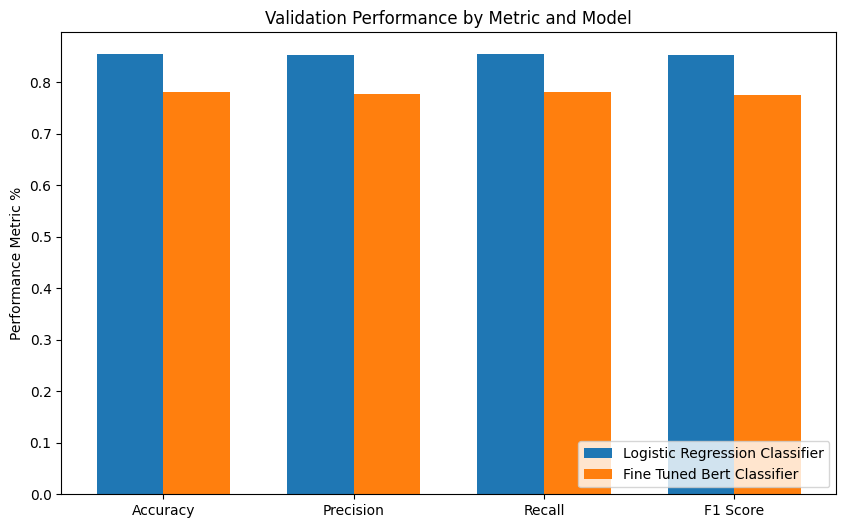

In [56]:
# Create a plot here to compare and contrast the performance between these models
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

lgr_scores = [accuracy_lgr, precision_lgr, recall_lgr, f1_lgr]
bert_scores = [accuracy_model2, precision_model2, recall_model2, f1_model2]

# create bar chart for labels
x = range(len(metrics_names))  # metric label location
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x, lgr_scores, bar_width, label='Logistic Regression Classifier')
rects2 = ax.bar([p + bar_width for p in x], bert_scores, bar_width, label='Fine Tuned Bert Classifier')

ax.set_ylabel('Performance Metric %')
ax.set_title('Validation Performance by Metric and Model')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(metrics_names)
ax.legend(loc="lower right")

## 4. Look at how the model generalises to the test set

Looking at how the models generalises to the test set of hand labeled text

In [58]:
# Generalise the results here on test set to see how the results generalise

In [59]:
news_test_df = pd.read_json("combined_data_output/news_analysis_test_set.json")
news_test_df.shape


(111, 47)

In [60]:
news_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   organizations                      111 non-null    object 
 1   uuid                               111 non-null    object 
 2   author                             64 non-null     object 
 3   url                                111 non-null    object 
 4   ord_in_thread                      111 non-null    int64  
 5   title                              111 non-null    object 
 6   locations                          111 non-null    object 
 7   highlightText                      0 non-null      float64
 8   language                           111 non-null    object 
 9   persons                            111 non-null    object 
 10  text                               111 non-null    object 
 11  external_links                     111 non-null    object 

In [61]:
news_test_df["human_prediction"].value_counts() # shows that we only have positive and negative class so this is fine

 1    66
-1    45
Name: human_prediction, dtype: int64

In [62]:
new_texts = news_test_df["text_full"].to_list()
len(new_texts)

111

In [63]:
new_texts[:5]

['European stocks shed more than one percent at open\nTip : Use comma (,) to separate multiple quotes. Learn more... \nWed, Aug 26, 2015, 09:38 BST - UK Markets close in 6 hrs 52 mins European stocks shed more than one percent at open AFP – 9 minutes ago View Photo \n\nEurope\'s stock markets fell by more than one percent at the open on Wednesday despite gains in Asia, as investor enthusiasm waned over China\'s interest rate cut. \nIn initial trade, London\'s benchmark FTSE 100 index lost 1.30 percent to 6,002.28 points, Frankfurt\'s DAX 30 tumbled 1.69 percent to 9,956.85 and the CAC 40 in Paris sank 1.44 percent to 4,499.23 points. \nEuropean markets had rebounded Tuesday after China cut interest rates in an attempt to boost the flagging Chinese economy, which had sent markets into a tailspin on Monday. \nWall Street also rallied on the news but optimism soon fizzled and New York ended with sharp losses. \nThe Dow Jones Industrial Average sank 1.29 percent as the market remained jitt

In [64]:
new_text_labels = news_test_df["human_prediction"].to_list()
len(new_text_labels)

111

In [69]:
new_text_labels = [1 if x == 1 else 0 for x in new_text_labels]

In [70]:
new_text_labels[:5]

[0, 1, 1, 1, 0]

In [71]:
lgr_threshold

0.5

#### 1. Test set performance on logistic regression

In [72]:
preprocessed_new_texts = [data_cleaner_sa(text) for text in new_texts]
# vectorise into tf-idf
X_lgr_new = lgr_vectoriser.transform(preprocessed_new_texts)

# predict the new text given vectorisation
lgr_test_probabilities = lgr_model.predict_proba(X_lgr_new)
lgr_test_predictions = np.where(lgr_test_probabilities[:, 1] >= lgr_threshold, 1, 0)

# output the predictions and visualise it here.

In [73]:
# for test set - use text_full and human_prediction to review and test how the models perform, in terms of the 4 scores we have above.

#### 2. Test performance on Pre-trained BERT Model

In [75]:
# load the model if need be

# Function to predict sentiment
def predict_sentiment(text, model, tokeniser, threshold = 0.5):
    # Tokenize the input text
    inputs = tokeniser(text, padding=True, truncation=True, max_length=512, return_tensors="pt")

    # move inputs to the same device as the model
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # predict
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        prediction = torch.sigmoid(logits).item()

    # interpret the output
    sentiment = 1 if prediction > threshold else 0
    return sentiment

In [77]:
bert_threshold

0.4

In [78]:
# just save the predictions here, with the right threshold

bert_test_predictions = []

bert_lgr_classifier.eval()
for text in new_texts:
    bert_test_predictions.append(predict_sentiment(text, bert_lgr_classifier, tokeniser, bert_threshold)) # use same tokeniser from before.

In [79]:
# logistic regression scores
test_accuracy_lgr = accuracy_score(new_text_labels, lgr_test_predictions)
test_precision_lgr = precision_score(new_text_labels, lgr_test_predictions, average='weighted')
test_recall_lgr = recall_score(new_text_labels, lgr_test_predictions, average='weighted')
test_f1_lgr = f1_score(new_text_labels, lgr_test_predictions, average='weighted')

# bert model scores
test_accuracy_bert = accuracy_score(new_text_labels, bert_test_predictions)
test_precision_bert = precision_score(new_text_labels, bert_test_predictions, average='weighted')
test_recall_bert = recall_score(new_text_labels, bert_test_predictions, average='weighted')
test_f1_bert = f1_score(new_text_labels, bert_test_predictions, average='weighted')

In [82]:
print("LGR Performance on Test Set")

print("Accuracy with threshold:", test_accuracy_lgr)
print("Precision with threshold:", test_precision_lgr)
print("Recall with threshold:", test_recall_lgr)
print("F1 Score with threshold:", test_f1_lgr)

LGR Performance on Test Set
Accuracy with threshold: 0.7387387387387387
Precision with threshold: 0.7935844935844937
Recall with threshold: 0.7387387387387387
F1 Score with threshold: 0.7387387387387386


In [83]:
print("Bert Performance on Test Set")

print("Accuracy with threshold:", test_accuracy_bert)
print("Precision with threshold:", test_precision_bert)
print("Recall with threshold:", test_recall_bert)
print("F1 Score with threshold:", test_f1_bert)

Bert Performance on Test Set
Accuracy with threshold: 0.6666666666666666
Precision with threshold: 0.696078431372549
Recall with threshold: 0.6666666666666666
F1 Score with threshold: 0.6691086691086692


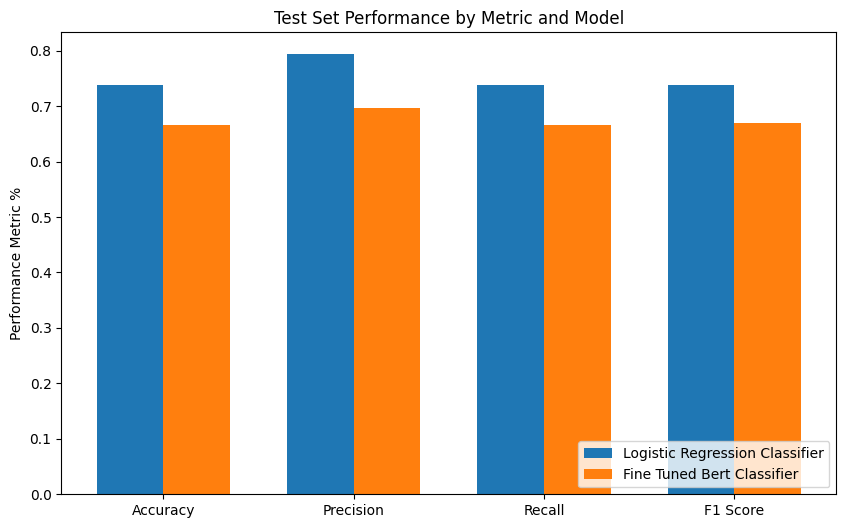

In [80]:
# add the final code for the graph here

# change the references here as needed

# Create a plot here to compare and contrast the performance between these models
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

lgr_scores_test_set = [test_accuracy_lgr, test_precision_lgr, test_recall_lgr, test_f1_lgr]
bert_scores_test_set = [test_accuracy_bert, test_precision_bert, test_recall_bert, test_f1_bert]

# create bar chart for labels
x = range(len(metrics_names))  # metric label location
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x, lgr_scores_test_set, bar_width, label='Logistic Regression Classifier')
rects2 = ax.bar([p + bar_width for p in x], bert_scores_test_set, bar_width, label='Fine Tuned Bert Classifier')

ax.set_ylabel('Performance Metric %')
ax.set_title('Test Set Performance by Metric and Model')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(metrics_names)
ax.legend(loc="lower right")